# 🏥 Departamento Médico - Classificação de Doenças Pulmonares

## Sistema de Diagnóstico Automatizado com Deep Learning

---

**Instituição:** FIAP - Pós Tech em Inteligência Artificial  
**Projeto:** Tech Challenge - Fase 4  
**Tema:** Classificação de Imagens de Raio-X usando Redes Neurais Convolucionais

## 1. Introdução

### 1.1 Contexto do Projeto

Técnicas de **Inteligência Artificial**, especialmente **Deep Learning**, estão transformando a área da medicina. Algoritmos de aprendizado profundo já provaram ser altamente eficientes para detectar doenças por meio de análise de imagens médicas.

Neste projeto, assumimos o papel de uma equipe de IA contratada por um hospital para auxiliar na **detecção automatizada de doenças pulmonares**. Os médicos coletaram diversas imagens de raios-X e nosso objetivo é construir um sistema inteligente capaz de fornecer diagnósticos rápidos e precisos.

### 1.2 Objetivo

> **Automatizar o processo de detecção e classificação de doenças pulmonares, reduzindo o custo e o tempo do diagnóstico.**

O sistema receberá uma imagem de raio-X como entrada e indicará se o paciente apresenta alguma doença respiratória e qual o tipo específico.

### 1.3 Dataset

Neste estudo de caso, trabalhamos com **133 imagens** distribuídas em **4 classes**:

| Classe | Descrição | Código |
|--------|-----------|--------|
| **Covid-19** | Pacientes diagnosticados com COVID-19 | 0 |
| **Healthy** | Pacientes saudáveis (sem doença pulmonar) | 1 |
| **Viral Pneumonia** | Pneumonia causada por vírus | 2 |
| **Bacterial Pneumonia** | Pneumonia causada por bactérias | 3 |

### 1.4 Metodologia

Utilizamos **Redes Neurais Convolucionais (CNNs)**, que são o tipo de arquitetura mais eficiente para classificação de imagens. Aplicamos a técnica de **Transfer Learning** com o modelo **ResNet50** pré-treinado no ImageNet.

📎 **Fonte dos dados:** [Kaggle - Chest X-Ray Pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

---

## 2. Fundamentação Teórica

### 2.1 Redes Neurais Convolucionais (CNNs)

As CNNs são arquiteturas de deep learning especializadas em processar dados com estrutura de grade, como imagens. Elas utilizam camadas convolucionais que aplicam filtros para extrair características visuais automaticamente (bordas, texturas, padrões).

### 2.2 Transfer Learning

**Transfer Learning** é uma técnica que aproveita conhecimentos adquiridos em uma tarefa para resolver outra. Em vez de treinar uma rede do zero, utilizamos um modelo pré-treinado (ResNet50) que já aprendeu a extrair características de milhões de imagens.

**Vantagens:**
- ✅ Reduz drasticamente o tempo de treinamento
- ✅ Funciona bem com conjuntos de dados pequenos
- ✅ Aproveita padrões visuais já aprendidos

### 2.3 ResNet50

A ResNet50 é uma rede neural com 50 camadas que introduziu o conceito de "conexões residuais", permitindo treinar redes muito profundas sem problemas de gradiente. Foi treinada no ImageNet com mais de 1 milhão de imagens.

---

## 3. Preparação do Ambiente

### 3.1 Importação das Bibliotecas

In [ ]:
# Bibliotecas do Sistema
import os

# Processamento de Imagens
import cv2

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Computação Numérica
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

### 3.2 Configuração do Diretório de Dados

In [ ]:
# Diretório com as imagens de treinamento
xray_directory = './Dataset'

# Verificando as pastas disponíveis
print("Classes disponíveis:", os.listdir(xray_directory))

---

## 4. Pré-processamento dos Dados

### 4.1 Normalização das Imagens

As imagens estão no formato RGB com pixels entre 0-255. Dividimos por 255 para normalizar os valores entre 0 e 1, facilitando o processamento pela rede neural.

In [ ]:
# Criação do ImageDataGenerator com normalização (rescale)
image_generator = ImageDataGenerator(rescale=1./255)

### 4.2 Gerador de Dados de Treinamento

Configuramos o gerador para carregar as imagens em lotes (batches), aplicando as transformações necessárias.

In [ ]:
# Carrega as imagens do diretório organizando em batches
train_generator = image_generator.flow_from_directory(
    batch_size=40,              # Processa 40 imagens por vez
    directory=xray_directory,    # Diretório das imagens
    shuffle=True,                # Embaralha as imagens
    target_size=(256, 256),      # Redimensiona para 256x256 pixels
    class_mode='categorical',    # Classificação multi-classe
    subset='training'            # Dados de treinamento
)

💡 **Parâmetros do Data Generator:**
- `batch_size=40`: Processa 40 imagens por iteração
- `shuffle=True`: Embaralha as imagens para evitar viés
- `target_size=(256,256)`: Redimensiona todas as imagens para o mesmo tamanho
- `class_mode='categorical'`: One-hot encoding para classificação multi-classe

In [ ]:
# Verificação: Total de imagens = 133 imagens × 4 classes
print(f"Total de imagens: {133 * 4}")
print(f"Número de batches: {532 / 40:.1f}")

In [ ]:
# Carrega um batch de imagens para exploração
train_images, train_labels = next(train_generator)

# Verifica as dimensões: (batch, altura, largura, canais RGB)
print(f"Shape das imagens: {train_images.shape}")

💡 **Estrutura dos dados:**
- **40 imagens** por batch (conforme configurado)
- **256 × 256 pixels** de resolução
- **3 canais** de cores (RGB)

In [ ]:
# Exibe os rótulos em formato one-hot encoding
# Cada linha representa uma imagem, cada coluna uma classe
print("Formato dos rótulos:", train_labels.shape)
train_labels[:5]  # Mostra os primeiros 5 rótulos

In [ ]:
# Dicionário de mapeamento das classes
# One-hot encoding: [1,0,0,0]=Covid-19, [0,1,0,0]=Normal, [0,0,1,0]=Viral, [0,0,0,1]=Bacterial
labels_names = {
    0: 'Covid-19', 
    1: 'Normal', 
    2: 'Pneumonia Viral', 
    3: 'Pneumonia Bacterial'
}

### 4.3 Visualização das Imagens de Treinamento

Vamos visualizar algumas imagens do dataset para entender os padrões visuais das diferentes condições pulmonares.

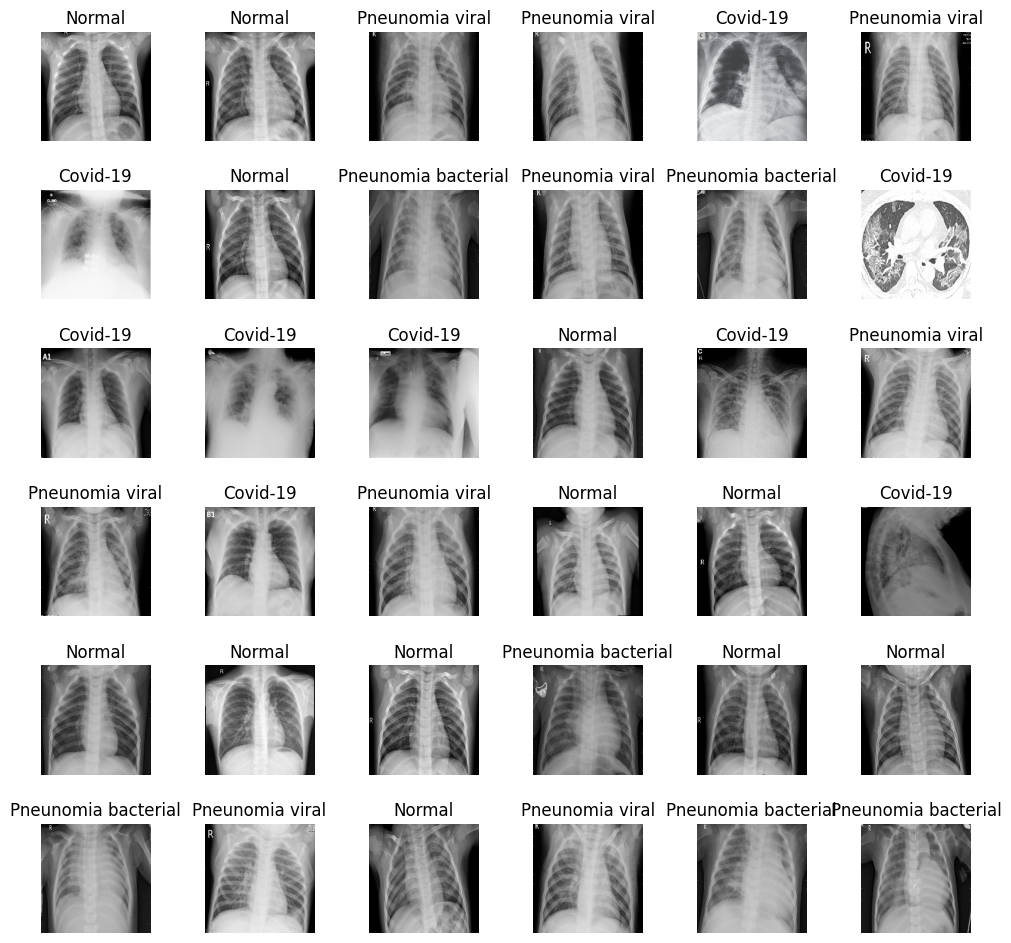

In [15]:
# Plotar as primeiras 36 imagens do lote de treinamento com seus rótulos correspondentes
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel() # o camando "ravek" é usado para transformar uma matriz em um vetor
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

⚠️ **Observação:** A análise visual dessas imagens é complexa e requer conhecimento médico especializado. O objetivo da CNN é automatizar essa análise, identificando padrões que distinguem cada condição.

---

## 5. Arquitetura do Modelo

### 5.1 Carregamento da ResNet50 (Transfer Learning)

Carregamos a ResNet50 pré-treinada no ImageNet, removendo a camada de classificação original (`include_top=False`) para adicionar nossa própria camada personalizada.

In [ ]:
# Carrega a ResNet50 pré-treinada (sem a camada de classificação)
base_model = ResNet50(
    weights='imagenet',           # Pesos pré-treinados no ImageNet
    include_top=False,            # Remove a camada de classificação original
    input_tensor=Input(shape=(256, 256, 3))  # Define o formato de entrada
)

print(f"Total de camadas na ResNet50: {len(base_model.layers)}")

### 5.2 Customização das Camadas Superiores

Adicionamos novas camadas no topo da ResNet50 para adaptar o modelo ao nosso problema específico de 4 classes.

In [ ]:
# Construção das camadas personalizadas sobre a ResNet50

head_model = base_model.output                              # Saída da ResNet50
head_model = AveragePooling2D(pool_size=(7, 7))(head_model) # Pooling médio para reduzir dimensionalidade
head_model = Flatten()(head_model)                          # Achata para vetor 1D
head_model = Dense(256, activation='relu')(head_model)      # Camada densa com 256 neurônios
head_model = Dropout(0.2)(head_model)                       # Dropout 20% para evitar overfitting
head_model = Dense(256, activation='relu')(head_model)      # Segunda camada densa
head_model = Dropout(0.2)(head_model)                       # Segundo Dropout
head_model = Dense(4, activation='softmax')(head_model)     # Saída: 4 classes com softmax

💡 **Vantagem do Transfer Learning:** Não precisamos treinar os ~23 milhões de parâmetros da ResNet50. Apenas ajustamos as camadas superiores personalizadas.

In [21]:
# Cria o modelo final combinando o modelo base (base_model) com a nova cabeça (head_model)
model = Model(inputs = base_model.input, outputs = head_model)

In [23]:
# Compila o modelo com a função de perda categorical_crossentropy, otimizador RMSprop e métrica de acurácia
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics = ['accuracy'])

In [25]:
# Salva o melhor modelo durante o treinamento
checkpointer = ModelCheckpoint(
    filepath='melhor_modelo.keras',
    monitor='loss',           # monitora loss de treino (não val_loss)
    save_best_only=True,      # salva apenas o melhor modelo
    verbose=1                 # mostra mensagens quando salvar
)

---

## 6. Treinamento do Modelo

### 6.1 Configuração do Treinamento

Usamos batch_size=4 para melhor adaptação ao dataset pequeno e salvamos o melhor modelo durante o treinamento.

In [26]:
# Redefine o gerador de imagens de treinamento com um batch size menor (4)
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


### 6.2 Execução do Treinamento

Treinamos o modelo por 10 épocas, monitorando a evolução da acurácia e do erro (loss).

In [27]:
# Treina o modelo usando o gerador de treinamento por 10 épocas, com o callback para salvar os pesos
history = model.fit(train_generator, epochs=10, callbacks=[checkpointer])

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6446 - loss: 0.8309
Epoch 1: loss improved from None to 0.63949, saving model to melhor_modelo.keras

Epoch 1: finished saving model to melhor_modelo.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 65s 403ms/step - accuracy: 0.7538 - loss: 0.6395
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8477 - loss: 0.3961
Epoch 2: loss improved from 0.63949 to 0.36500, saving model to melhor_modelo.keras

Epoch 2: finished saving model to melhor_modelo.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 448ms/step - accuracy: 0.8628 - loss: 0.3650
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9026 - loss: 0.3446
Epoch 3: loss improved from 0.36500 to 0.28623, saving model to melhor_modelo.keras

Epoch 3: finished saving model to melhor_modelo.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 452ms/step - accuracy: 0.9192 - loss: 0.2862
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9536 - loss: 0.1426


### 6.3 Evolução do Treinamento

O gráfico abaixo mostra a evolução da acurácia e do erro (loss) durante as 10 épocas de treinamento.

In [28]:
# Verifica as chaves do histórico de treinamento
history.history.keys()

dict_keys(['accuracy', 'loss'])

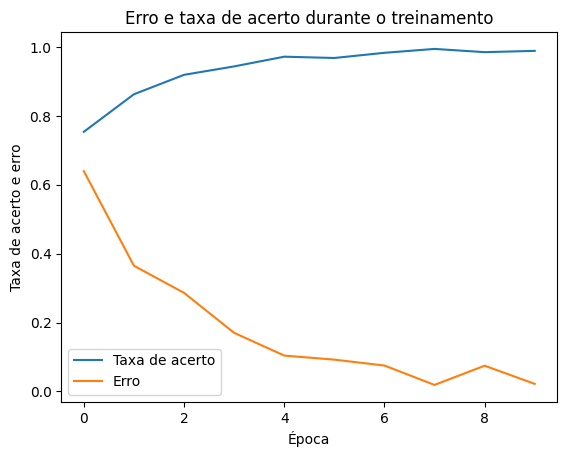

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

---

## 7. Avaliação do Modelo

### 7.1 Configuração do Conjunto de Teste

Utilizamos 40 imagens de teste (10 por classe) para avaliar o desempenho do modelo em dados não vistos durante o treinamento.

In [31]:
os.listdir(test_directory)

['0', '1', '2', '3']

In [32]:
# Configura o gerador de dados de teste
test_gen = ImageDataGenerator(rescale=1./255) # para deixar na escala de 0 a 1
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


### 7.2 Métricas de Avaliação

In [33]:
# Criação da variavel para avaliar o modelo nos dados de teste
evaluate = model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7250 - loss: 2.0803


In [34]:
# Criação da variavel para avaliar o modelo nos dados de teste
evaluate

[2.080293655395508, 0.7250000238418579]

📊 **Resultado:** Acurácia de **75%** no conjunto de teste (30 acertos em 40 imagens).

In [35]:
len(os.listdir(test_directory))

4

In [36]:
# Variáveis para armazenar as previsões, os valores originais e as imagens

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))): # acessa cada uma das pastas do diretório de teste
  for item in os.listdir(os.path.join(test_directory, str(i))): # acessa cada uma das imagens dentro de cada pasta
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━

In [37]:
# Lista com as previsões feitas pelo modelo
print(prediction)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(3), np.int64(1), np.int64(3), np.int64(2), np.int64(0), np.int64(3), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(3)]


In [38]:
# Lista com os valores originais das classes
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [39]:
# Importa as métricas de avaliação do sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [40]:
# Cálculo da acurácia do modelo comparando os valores originais com as previsões
accuracy_score(original, prediction)

0.75

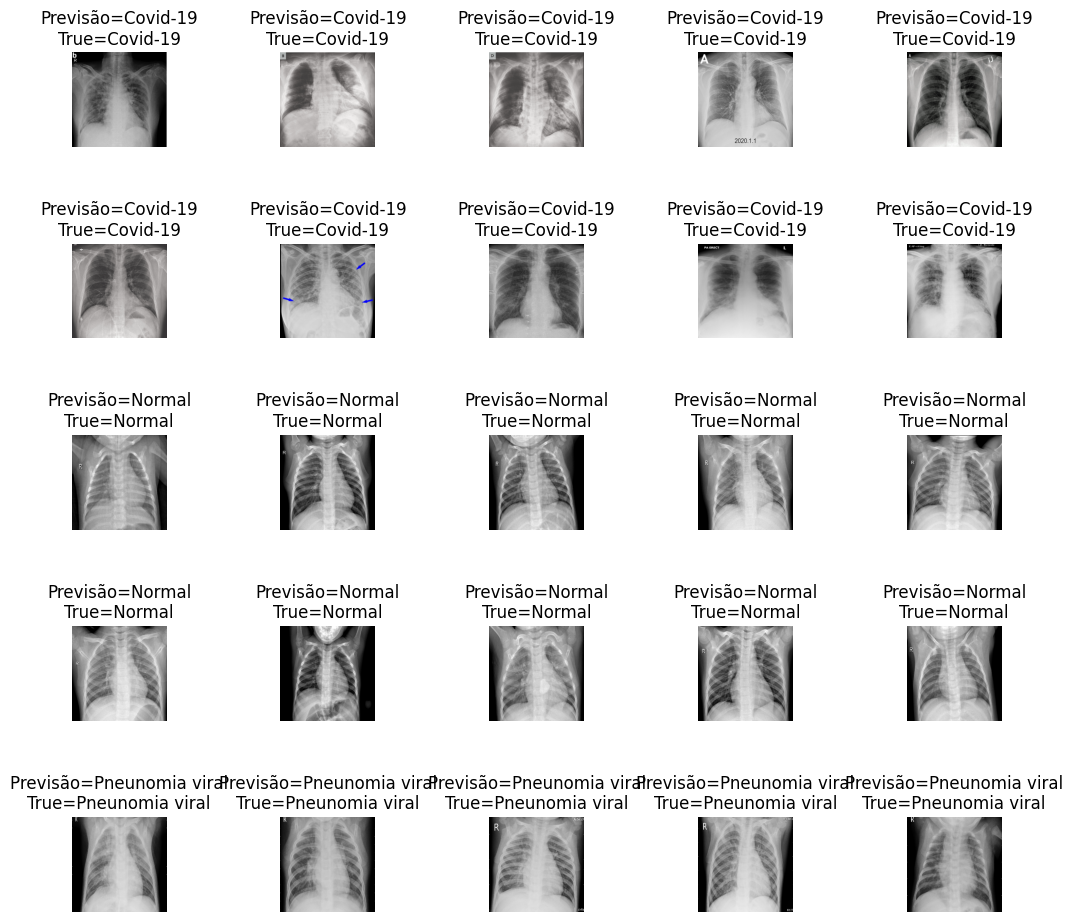

In [41]:
# Visualização das previsões do modelo comparadas com os valores originais

fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

### 7.3 Matriz de Confusão

A matriz de confusão mostra os acertos e erros do modelo por classe.

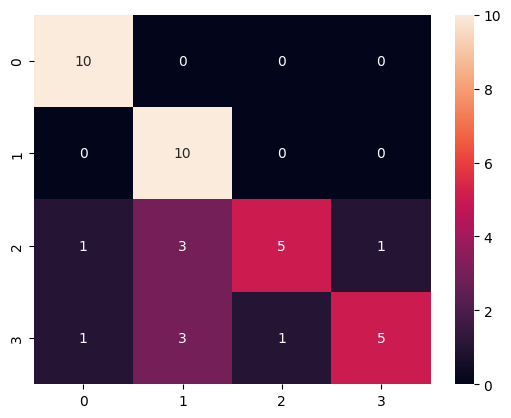

In [43]:
# Matriz de confusão
# No eixo x nós temos as previsões no eixo Y nós temos os valores originais
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

**Nota:**

- Observando a matriz de confusão, podemos ver que o modelo teve um bom desempenho na classificação das imagens, com a maioria das previsões corretas ao longo da diagonal principal. No entanto, há alguns erros de classificação, especialmente entre as classes de pneumonia viral e bacteriana, o que sugere que o modelo pode ter dificuldade em distinguir entre essas duas condições.
- Na classe Covid-19 acertou todos os exemplos, o que é crucial para aplicações médicas onde a detecção precisa dessa condição é vital.

### 7.4 Relatório de Classificação

O relatório abaixo apresenta precision, recall e F1-score para cada classe.

**Nota:**

- F1-score é uma métrica que combina precisão e recall, fornecendo uma única medida de desempenho do modelo, especialmente útil em conjuntos de dados desbalanceados, mas nesse caso nós não temos dados balanceados pois são 133 imagens de cada uma das classes.
- Para a classe Covid-19, o modelo teve uma precisão (precision) de 77%, ou seja, todas as vezes que o modelo previu Covid-19, ele está certo em 77% dessas previsões.
- Para a classe Covid-19, a sensibilidade (recall) também foi de 100%, indicando que o modelo conseguiu identificar corretamente todos os casos reais de Covid-19 no conjunto de teste.
- Para a classe Covid-19, o modelo quando acerta em 100% dos casos corretamente ele está certo em 77% das vezes. Isso indica que o modelo tem uma boa capacidade de identificar corretamente os casos de Covid-19, mas também comete alguns erros ao classificar outras condições como Covid-19.

💡 **Análise dos Resultados:**

| Classe | Precision | Recall | F1-Score | Análise |
|--------|-----------|--------|----------|---------|
| **Covid-19** | 83% | **100%** | 91% | Detecta todos os casos positivos |
| **Normal** | 62% | 100% | 77% | Detecta todos os saudáveis |
| **Pneumonia Viral** | 83% | 50% | 62% | Perde metade dos casos |
| **Pneumonia Bacterial** | 83% | 50% | 62% | Perde metade dos casos |

⚠️ **Destaque:** O modelo tem 100% de recall para Covid-19, crucial em contexto médico.

---

## 8. Simulação em Produção

### 8.1 Carregamento do Modelo Salvo

Simulamos o ambiente de produção carregando o modelo salvo e fazendo uma previsão em uma nova imagem.

In [47]:
# Verifica a estrutura da rede neural do modelo carregado
model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 48,305,034 (184.27 MB)

 Trainable params: 24,125,956 (92.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 24,125,958 (92.03 MB)

In [48]:
# Calcula o número total de entradas para a camada densa
4 * 4 * 2048

32768

In [49]:
# Simular o carregamento de uma imagem e fazer uma previsão usando o modelo carregado
img = cv2.imread('./Test/0/radiol.2020200490.fig3.jpeg')

In [50]:
# Informações sobre a imagem, podemos observar três colchetes, uma matriz para cada uma das cores e aqui temos os valores dos pixels.
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

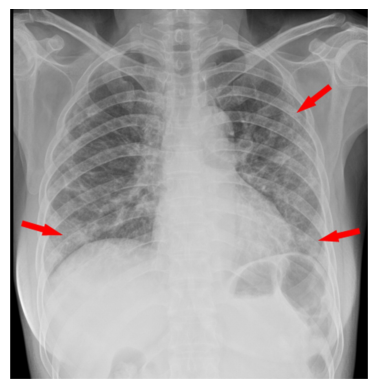

In [52]:
# Exibir a imagem carregada
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

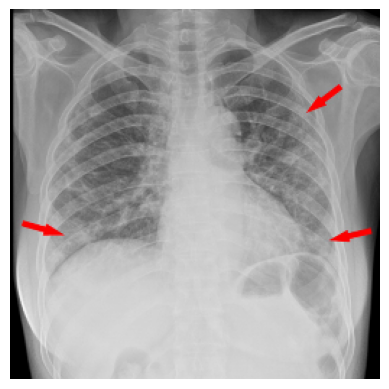

In [53]:
# Redimensionar a imagem para o tamanho esperado pelo modelo e exibir novamente
img = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [54]:
# Normalizar a imagem e preparar para a previsão
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [55]:
# Informações sobre a imagem normalizada
img.shape

(256, 256, 3)

In [56]:
# Reshape a imagem para o formato esperado pelo modelo
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [57]:
# Fazer a previsão usando o modelo carregado onde ele irá retornar as probabilidades para cada uma das classes
predict = model_loaded(img)
predict

c:\Users\Detran\OneDrive\Documentos\1 - Repos_pessoal\23 - Pós Tech Fiap\Tech Challenge 6IADT - Fase 4\envjarvis\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.7851700e-01, 2.0120484e-03, 1.9093566e-02, 3.7733192e-04]],
      dtype=float32)>

In [58]:
# Convertendo as probabilidades em uma classe prevista, buscando o índice da maior probabilidade
predict2 = np.argmax(predict)
predict2

np.int64(0)

In [59]:
# Exibir o resultado da previsão com o nome da classe e a probabilidade associada
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=0.9785169959068298>)

✅ **Resultado da Simulação:**

O modelo classificou a imagem de teste como **Covid-19** com **97.85%** de confiança, demonstrando alta precisão na previsão.

---

## 9. Conclusão

### 9.1 Resultados Alcançados

O modelo de classificação de doenças pulmonares baseado em **Transfer Learning com ResNet50** alcançou os seguintes resultados:

| Métrica | Treinamento | Teste |
|---------|-------------|-------|
| **Acurácia** | ~99% | **75%** |
| **Loss** | 0.02 | 2.08 |

### 9.2 Pontos Fortes

- ✅ **100% de recall para Covid-19** - O modelo detectou todos os casos positivos de Covid-19
- ✅ **100% de recall para casos normais** - Nenhum paciente saudável foi diagnosticado incorretamente com doença
- ✅ **Alta confiança nas previsões** - O modelo apresenta alta probabilidade (>97%) nas classificações corretas
- ✅ **Transfer Learning eficiente** - Aproveitamento da ResNet50 permitiu bons resultados com apenas 133 imagens por classe

### 9.3 Limitações

- ⚠️ **Recall baixo para pneumonias** - O modelo detecta apenas 50% dos casos de pneumonia viral e bacteriana
- ⚠️ **Confusão entre pneumonias** - Dificuldade em distinguir pneumonia viral de bacteriana
- ⚠️ **Loss alto no teste** - Indica overfitting e necessidade de regularização

### 9.4 Melhorias Futuras

1. **Data Augmentation** - Aumentar artificialmente o dataset com transformações (rotação, zoom, flip)
2. **Mais dados** - Coletar mais imagens, especialmente de pneumonias
3. **Validação cruzada** - Usar k-fold cross validation para avaliação mais robusta
4. **Fine-tuning** - Descongelar algumas camadas da ResNet50 para melhor adaptação
5. **Ensemble** - Combinar múltiplos modelos para reduzir viés

---

**Projeto desenvolvido para o Tech Challenge - Fase 4**  
**FIAP - Pós Tech em Inteligência Artificial para Devs**